In [132]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import os

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

from IPython.core.display import display, HTML

import category_encoders as ce

#**Reading all the files**

# stores.csv

In [133]:
stores = pd.read_csv('stores.csv')
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [134]:
print("Types of stores:")
stores['Type'].value_counts()

Types of stores:


Type
A    22
B    17
C     6
Name: count, dtype: int64

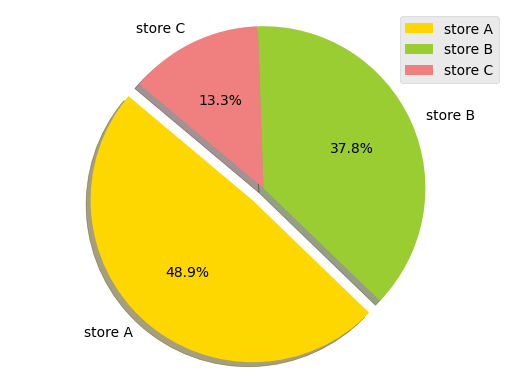

In [135]:
#pie-chart for the visual representation of store types
#https://pythonspot.com/matplotlib-pie-chart/
# Data to plot
labels = 'store A','store B','store C'
sizes = [(22/(45))*100,(17/(45))*100,(6/(45))*100]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.show()

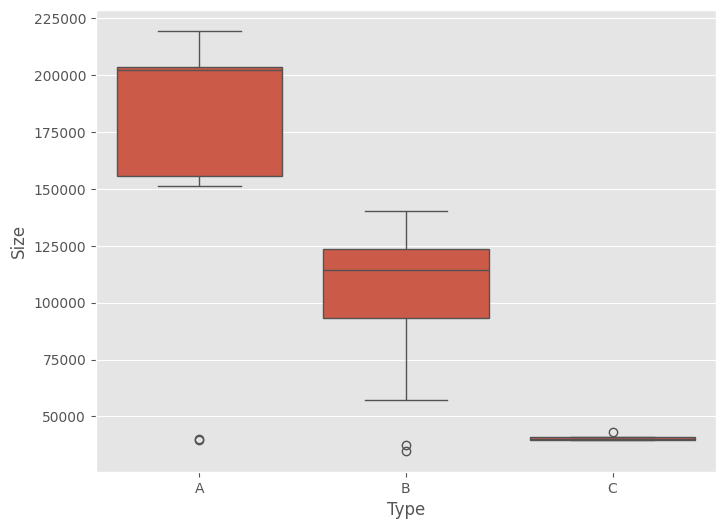

In [136]:
# boxplot for sizes of types of stores
store_type = pd.concat([stores['Type'], stores['Size']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=store_type)

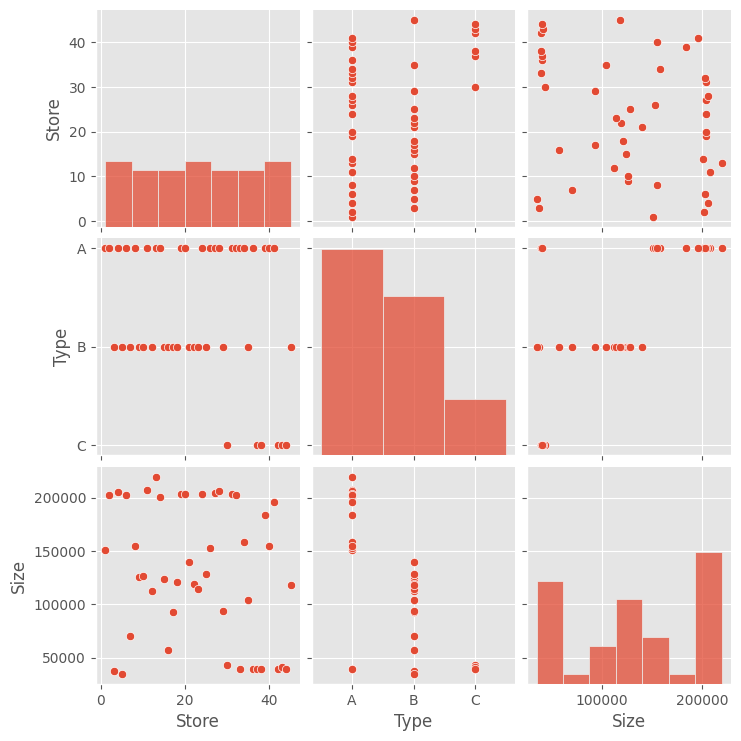

In [137]:
sns.pairplot(stores, vars=['Store','Type','Size'])

There are 45 stores in total, classified into three types: A, B, and C. Analysis using boxplots and pie charts indicates that Type A stores are the largest, while Type C stores are the smallest. The sizes of stores in each type do not overlap.

# train.csv

In [138]:
train = pd.read_csv('train.csv')
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


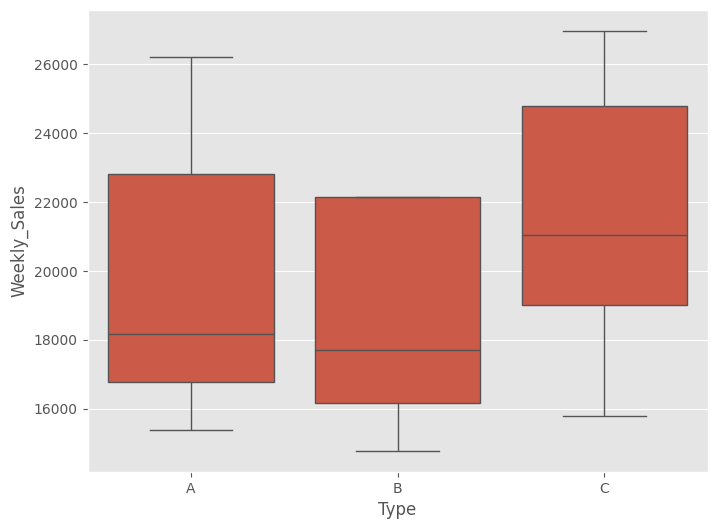

In [139]:
#boxplot for weekly sales for different types of stores :
store_sale = pd.concat([stores['Type'], train['Weekly_Sales']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=store_sale, showfliers=False)

In [140]:
train['IsHoliday'].value_counts()

IsHoliday
False    391909
True      29661
Name: count, dtype: int64

In [141]:
objects = ('Non holidays','Holidays')
y_pos = np.arange(len(objects))
y_pos

array([0, 1])

In [142]:
# total count of sales on holidays and non holidays
print('sales on non-holiday : ',train[train['IsHoliday']==False]['Weekly_Sales'].count().round(1))
print('sales on holiday : ',train[train['IsHoliday']==True]['Weekly_Sales'].count().round(1))

sales on non-holiday :  391909
sales on holiday :  29661


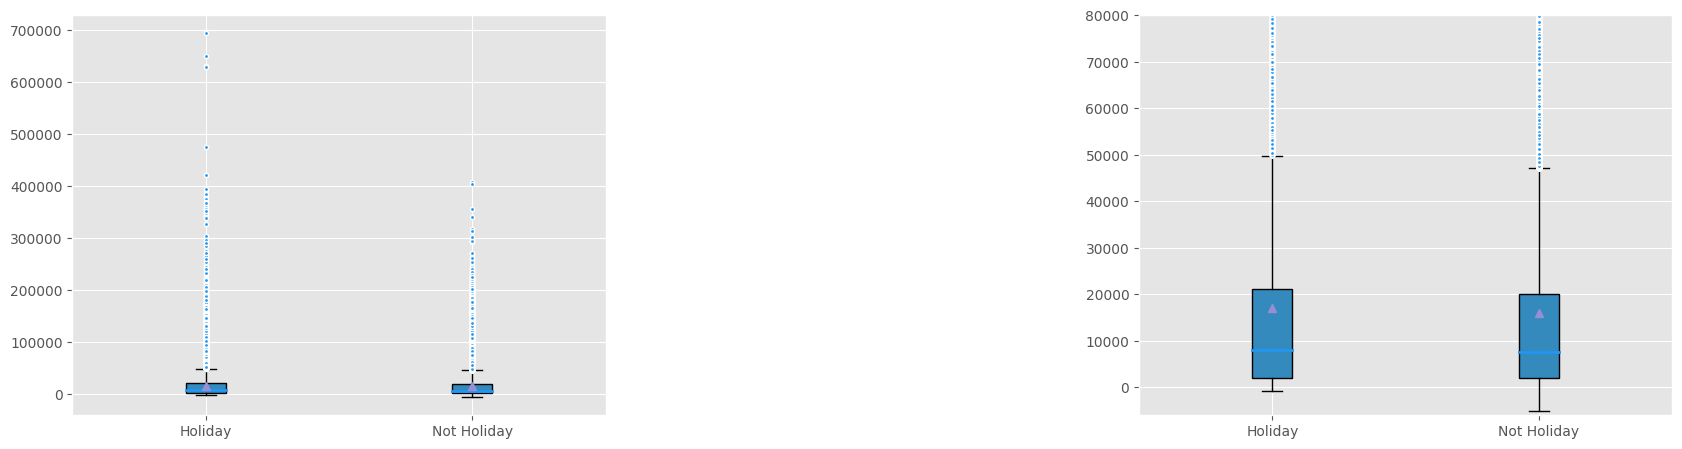

In [143]:
#https://www.kaggle.com/yepp2411/walmart-prediction-1-eda-with-time-and-space
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2, figsize = (20,5))
fig.subplots_adjust(wspace=1, hspace=1)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

sales_holiday=train[['IsHoliday','Weekly_Sales']]
target=[sales_holiday['Weekly_Sales'].loc[sales_holiday['IsHoliday']==True],sales_holiday['Weekly_Sales'].loc[sales_holiday['IsHoliday']==False]]
labels=['Holiday','Not Holiday']

#median
medianprop={'color':'#2196F3',
            'linewidth': 2,
            'linestyle':'-'}
# outliers

flierprop={'color' : '#EC407A',
          'marker' : 'o',
          'markerfacecolor': '#2196F3',
          'markeredgecolor':'white',
          'markersize' : 3,
          'linestyle' : 'None',
          'linewidth' : 0.1}



axes[0].boxplot(target,labels=labels, patch_artist = 'Patch',
                  showmeans=True,
                  flierprops=flierprop,
                  medianprops=medianprop)


axes[1].boxplot(target,labels=labels, patch_artist = 'Patch',
                  showmeans=True,
                  flierprops=flierprop,
                  medianprops=medianprop)

axes[1].set_ylim(-6000,80000)

plt.show()

<Axes: xlabel='Dept'>

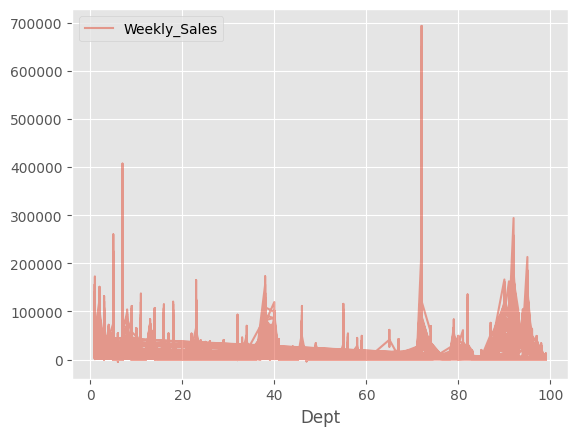

In [144]:
train.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=0.5,fig=(4,5))

Sales during the holidays are slightly higher than sales during non-holiday periods. From this plot, we notice that the department with the highest sales is between Department 60 and Department 80.

# test.csv

In [145]:
test = pd.read_csv('test.csv')
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


We have 421,570 values for training and 115,064 for testing in the competition. However, we will focus only on the 421,570 data points since we have labels to evaluate the models' performance and accuracy.

# features.csv

In [146]:
features = pd.read_csv('features.csv')
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


*Advance features*

In [147]:
#https://stackoverflow.com/questions/33365055/attributeerror-can-only-use-dt-accessor-with-datetimelike-values
#https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetime-properties
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

#week feature
train['Week'] = train['Date'].dt.isocalendar().week  # Use .dt.isocalendar().week to get week of year
test['Week'] = test['Date'].dt.isocalendar().week  # Use .dt.isocalendar().week to get week of year

In [148]:
train['Day_of_week'] =train['Date'].dt.dayofweek
test['Day_of_week'] =test['Date'].dt.dayofweek

train['Month'] =train['Date'].dt.month
test['Month'] =test['Date'].dt.month

train['Year'] =train['Date'].dt.year
test['Year'] =test['Date'].dt.year

train['Day'] =train['Date'].dt.day
test['Day'] =test['Date'].dt.day

In [149]:
#train data
#let's take mean of Temp and Unemployment
train['Temp_mean'] = features['Temperature'].mean()
train['Unemployment_mean'] = features['Unemployment'].mean()

#test data
test['Temp_mean'] = features['Temperature'].mean()
test['Unemployment_mean'] = features['Unemployment'].mean()

*Merge all the features*

In [150]:
features['Date'] = pd.to_datetime(features['Date'])

#merge all the features
train_with_feature = pd.merge_asof(train, features, on='Store',by='Date')
test_with_feature = pd.merge_asof(test, features, on='Store',by='Date')

train_with_feature.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Week,Day_of_week,Month,Year,Day,...,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,5,4,2,2010,5,...,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,6,4,2,2010,12,...,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,7,4,2,2010,19,...,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,8,4,2,2010,26,...,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,9,4,3,2010,5,...,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [151]:
#merge all the features
train_with_feature_new = pd.merge(train_with_feature,stores)
test_with_feature_new = pd.merge(test_with_feature,stores)
train_with_feature_new.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Week,Day_of_week,Month,Year,Day,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,5,4,2,2010,5,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,6,4,2,2010,12,...,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,7,4,2,2010,19,...,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,8,4,2,2010,26,...,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,9,4,3,2010,5,...,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [152]:
#drop the duplicate of IsHoliday column
train_with_feature = train_with_feature_new.drop(columns=['IsHoliday_x'])
test_with_feature = test_with_feature_new.drop(columns=['IsHoliday_x'])

#let's rename the IsHoliday_y column to IsHoliday
train_with_feature = train_with_feature.rename(columns={"IsHoliday_y": "IsHoliday"})
test_with_feature = test_with_feature.rename(columns={"IsHoliday_y": "IsHoliday"})

train_with_feature.head()

,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day,Temp_mean,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,59.356198,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,59.356198,...,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,59.356198,...,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,8,4,2,2010,26,59.356198,...,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,9,4,3,2010,5,59.356198,...,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [153]:
test_with_feature.head()

,Store,Dept,Date,Week,Day_of_week,Month,Year,Day,Temp_mean,Unemployment_mean,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2012-11-02,44,4,11,2012,2,59.356198,7.826821,...,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,A,151315
1,1,1,2012-11-09,45,4,11,2012,9,59.356198,7.826821,...,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,False,A,151315
2,1,1,2012-11-16,46,4,11,2012,16,59.356198,7.826821,...,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,False,A,151315
3,1,1,2012-11-23,47,4,11,2012,23,59.356198,7.826821,...,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,True,A,151315
4,1,1,2012-11-30,48,4,11,2012,30,59.356198,7.826821,...,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,False,A,151315


Changing IsHoliday column with Flase to be 0 and True to be 1 using one hot encoding.

In [154]:
train_with_feature['IsHoliday'] = train_with_feature['IsHoliday'].astype(int)
test_with_feature['IsHoliday'] = test_with_feature['IsHoliday'].astype(int)
print(train_with_feature.head(3))
print(test_with_feature.head(3))

   Store  Dept       Date  Weekly_Sales  Week  Day_of_week  Month  Year  Day  \
0      1     1 2010-02-05      24924.50     5            4      2  2010    5   
1      1     1 2010-02-12      46039.49     6            4      2  2010   12   
2      1     1 2010-02-19      41595.55     7            4      2  2010   19   

   Temp_mean  ...  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0  59.356198  ...        NaN        NaN        NaN        NaN        NaN   
1  59.356198  ...        NaN        NaN        NaN        NaN        NaN   
2  59.356198  ...        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  IsHoliday  Type    Size  
0  211.096358         8.106          0     A  151315  
1  211.242170         8.106          1     A  151315  
2  211.289143         8.106          0     A  151315  

[3 rows x 23 columns]
   Store  Dept       Date  Week  Day_of_week  Month  Year  Day  Temp_mean  \
0      1     1 2012-11-02    44            4     11  2